# Deployed Model link : [AI Food classifier](https://github.com/Umerkhalid1999/ML/blob/main/AI_recipe.ipynb)

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/food41
!unzip food41.zip -d food41

In [ ]:
import os
import shutil
import random

# Paths
original_images_path = "/content/food41/images"
subset_path = "food-101-subset"

# Parameters
num_classes = 10  # Number of classes to sample
images_per_class = 100  # Number of images per class

# Create subset directory
if not os.path.exists(subset_path):
    os.makedirs(subset_path)

# Select classes and copy images
selected_classes = random.sample(os.listdir(original_images_path), num_classes)

for food_class in selected_classes:
    class_path = os.path.join(original_images_path, food_class)
    target_class_path = os.path.join(subset_path, food_class)

    # Create class directory in subset
    os.makedirs(target_class_path, exist_ok=True)

    # Randomly select images
    selected_images = random.sample(os.listdir(class_path), images_per_class)
    for image in selected_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(target_class_path, image))

print(f"Subset created with {num_classes} classes and {images_per_class} images per class.")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: ImageDataGenerator
data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load training and validation data
train_data = data_gen.flow_from_directory(
    subset_path,
    target_size=(224, 224),
    batch_size=32,
    subset="training",
    class_mode="categorical"
)

validation_data = data_gen.flow_from_directory(
    subset_path,
    target_size=(224, 224),
    batch_size=32,
    subset="validation",
    class_mode="categorical"
)

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNet model
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(train_data.class_indices), activation="softmax")(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_steps=len(validation_data)
)



In [ ]:
import cv2

# Preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess the image for model prediction:
    1. Resize the image to target size.
    2. Normalize pixel values to the range [0, 1].
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Resize to target size
    image = cv2.resize(image, target_size)

    # Normalize pixel values
    image = image / 255.0

    return image


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted food item: donuts


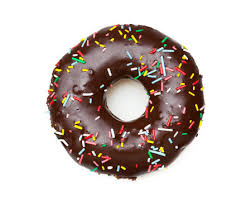

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import cv2
from google.colab.patches import cv2_imshow

# Load the trained model
model = load_model("food_recognition_subset_model.h5")

# Define preprocess_image function above this point

# Predict food category
def classify_image(image_path):
    """
    Classify a single image using the trained model.
    """
    image = preprocess_image(image_path)  # Ensure this function is defined
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(image)
    class_index = np.argmax(predictions)
    class_label = list(train_data.class_indices.keys())[class_index]
    return class_label

# Example: Classify an image
test_image_path = "/content/donut.jpeg"
predicted_label = classify_image(test_image_path)
print(f"Predicted food item: {predicted_label}")

cv2_imshow(cv2.imread(test_image_path))
cv2.waitKey(0)
cv2.destroyAllWindows()

Predicted food item: pumpkin muffin



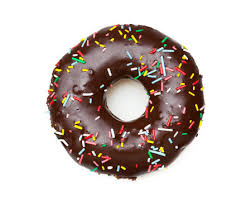

Recipe Name: Homemade Pumpkin Muffins

Ingredients:
- baking powder
- baking soda
- pumpkin
- cinnamon
- eggs
- flour
- ground cloves
- ground ginger
- nutmeg
- salt
- sugar
- vegetable oil

Instructions:
- 1. Preheat oven to 350. Prepare muffin pan with liners.In a large bowl mix mix flour and sugar. Add spices, baking soda, and salt  and then mix well.In a separate bowl, mix together pumpkin, oil, and eggs. Add mixture to dry ingredients. Mix until just blended. Too much mixing makes tough muffins  and nobody wants that.Fill muffin liners 2/3 full. Bake for 20-25 minutes until done. A fork or toothpick inserted into muffins should come out cleanly. Enjoy with a nice mug of coffee, tea, or apple cider.


In [ ]:
import requests
import re
import cv2
from google.colab.patches import cv2_imshow

# Spoonacular API settings
API_KEY = "ed20cd1e0a5e4e83831f587399444f6c"
API_URL = "https://api.spoonacular.com/recipes/complexSearch"
RECIPE_DETAIL_URL = "https://api.spoonacular.com/recipes/{}/information"  # Endpoint to get recipe details


# Function to clean up instructions (remove HTML tags, and format them properly)
def clean_instructions(instructions):
    # Remove HTML tags using regex
    clean_text = re.sub(r'<.*?>', '', instructions)

    # Split the instructions into steps (based on list-like structure or periods)
    steps = clean_text.split('\n')

    # Clean up empty steps or extra spaces
    steps = [step.strip() for step in steps if step.strip()]

    # If steps are in numbered list format, treat them as ordered steps
    formatted_steps = [f"{i+1}. {step}" for i, step in enumerate(steps)]

    return formatted_steps

# Function to fetch recipes
def fetch_recipe_from_api(food_item):
    params = {
        "query": food_item,
        "number": 1,  # Number of recipes to fetch
        "apiKey": API_KEY
    }
    response = requests.get(API_URL, params=params)
    data = response.json()

    if "results" in data and len(data["results"]) > 0:
        recipe = data["results"][0]

        # Fetch detailed recipe information (including ingredients)
        recipe_id = recipe['id']
        recipe_detail_response = requests.get(RECIPE_DETAIL_URL.format(recipe_id), params={"apiKey": API_KEY})
        recipe_detail = recipe_detail_response.json()

        ingredients = [ingredient['name'] for ingredient in recipe_detail.get('extendedIngredients', [])]
        instructions = recipe_detail.get('instructions', "Instructions not available")

        return {
            "recipe_name": recipe.get("title", "N/A"),
            "ingredients": ingredients,
            "instructions": instructions
        }
    else:
        return {"recipe_name": "No Recipe Found", "ingredients": [], "instructions": "N/A"}

# Image classification and recipe fetch
test_image_path = "/content/donut.jpeg"  # Path to your image
predicted_label = classify_image(test_image_path)  # Get the predicted label
print(f"Predicted food item: {predicted_label}\n")

# Display the image
cv2_imshow(cv2.imread(test_image_path))
cv2.waitKey(0)
cv2.destroyAllWindows()

# Fetch the recipe based on the predicted label
recipe = fetch_recipe_from_api(predicted_label)

# Clean output for better clarity
print(f"Recipe Name: {recipe['recipe_name']}\n")

if recipe['ingredients']:
    print("Ingredients:")
    for ingredient in recipe['ingredients']:
        print(f"- {ingredient}")
else:
    print("Ingredients: N/A")

print("\nInstructions:")

# Check if instructions are available
if recipe['instructions'] != "N/A":
    # Clean and format the instructions for clarity
    formatted_steps = clean_instructions(recipe['instructions'])

    # Printing each formatted step
    for step in formatted_steps:
        print(f"- {step}")
else:
    print("Instructions: N/A")


